## Imports

In [1]:
import time
from pprint import pprint
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import helper_utils
import model_architectures

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# OptimizedCNN
model_CNN = model_architectures.OptimizedCNN()

# ResNet-34
model_resnet = model_architectures.ResNet34()

In [4]:
def get_data_loaders_with_validation(batch_size, val_fraction=0.1):
    """Creates and returns data loaders for training, validation, and testing.

    Args:
        batch_size: The number of samples per batch in each data loader.
        val_fraction: The fraction of the training data to use for validation.

    Returns:
        A tuple containing the training, validation, and test data loaders.
    """
    # Define the transformations for the training data, including augmentation.
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Define the transformations for the validation and test data (no augmentation).
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the full CIFAR-10 training dataset.
    full_trainset = datasets.CIFAR10(root='/tmp/cifar10', train=True, download=True, transform=transform_train)
    # Calculate the number of samples for the training and validation sets.
    total_train = len(full_trainset)
    val_size = int(val_fraction * total_train)
    train_size = total_train - val_size

    # Split the full training set into separate training and validation sets.
    train_set, val_set = random_split(full_trainset, [train_size, val_size])

    # Apply the non-augmented test transform to the validation set.
    val_set.dataset.transform = transform_test

    # Load the CIFAR-10 test dataset.
    test_set = datasets.CIFAR10(root='/tmp/cifar10', train=False, download=True, transform=transform_test)

    # Create DataLoader instances for each dataset split.
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    # Return the created data loaders.
    return train_loader, val_loader, test_loader

In [5]:
def train_and_evaluate(model, optimizer, scheduler, device, n_epochs, train_loader, val_loader):
    """Manages the main training and evaluation loop for a model.

    Args:
        model: The PyTorch model to train.
        optimizer: The optimizer for updating model weights.
        scheduler: The learning rate scheduler (can be None).
        device: The device ('cpu' or 'cuda') to perform computations on.
        n_epochs: The total number of epochs to train for.
        train_loader: The DataLoader for the training data.
        val_loader: The DataLoader for the validation data.
    """
    # Move the model to the specified compute device.
    model = model.to(device)

    # Define the loss function.
    loss_fcn = nn.CrossEntropyLoss()

    # Initialize the progress bar for visualizing the training process.
    pbar = helper_utils.NestedProgressBar(total_epochs=n_epochs, total_batches=len(train_loader), epoch_message_freq=1)

    # Loop through the specified number of epochs.
    for epoch in range(n_epochs):
        # Update the epoch-level progress bar for the new epoch.
        pbar.update_epoch(epoch+1)

        # Perform one epoch of training and get the average training loss.
        train_loss, _ = helper_utils.train_epoch(model, train_loader, optimizer, loss_fcn, device, pbar)
        
        # Evaluate the model's accuracy on the validation set.
        val_acc = helper_utils.evaluate_accuracy(model, val_loader, device)

        # Log the training loss and validation accuracy for the current epoch.
        pbar.maybe_log_epoch(epoch+1, message=f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check if a learning rate scheduler is being used.
        if scheduler is not None:
            # Handle the ReduceLROnPlateau scheduler, which requires a metric.
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            # For other schedulers, step without a metric.
            else:
                scheduler.step()

    # Close the progress bar and print a final completion message.
    pbar.close("Training complete!")

In [6]:
n_epochs = 10

# Data loaders
batch_size = 128
train_loader, val_loader, test_loader = get_data_loaders_with_validation(batch_size=batch_size, val_fraction=0.1)

In [7]:
optimizer_CNN = optim.Adam(model_CNN.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_CNN = optim.lr_scheduler.ReduceLROnPlateau(optimizer_CNN, 'max', patience=3, factor=0.5)

# Train and evaluate the OptimizedCNN model
train_and_evaluate(model_CNN, optimizer_CNN, scheduler_CNN, device, n_epochs, train_loader, val_loader)

Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.4278, Val Acc: 0.5662


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.0048, Val Acc: 0.6560


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.8676, Val Acc: 0.6878


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.7845, Val Acc: 0.6976


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.7125, Val Acc: 0.7236


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.6502, Val Acc: 0.7216


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.5928, Val Acc: 0.7210


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.5480, Val Acc: 0.7514


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.5010, Val Acc: 0.7570


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.4587, Val Acc: 0.7460
Training complete!


In [8]:
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler_resnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=200)

# Train and evaluate the ResNet-34 model
train_and_evaluate(model_resnet, optimizer_resnet, scheduler_resnet, device, n_epochs, train_loader, val_loader)

Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 2.0499, Val Acc: 0.3756


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.4693, Val Acc: 0.5004


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.1940, Val Acc: 0.6008


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.9790, Val Acc: 0.6176


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.8212, Val Acc: 0.6972


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.6883, Val Acc: 0.7500


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.5737, Val Acc: 0.7454


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.5050, Val Acc: 0.7134


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.4470, Val Acc: 0.7768


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.3972, Val Acc: 0.7904
Training complete!


In [9]:
def get_model_size(model):
    """Calculates the total size of a PyTorch model in megabytes (MB).

    Args:
        model: The PyTorch model (nn.Module) whose size is to be calculated.

    Returns:
        The total size of the model in megabytes (MB).
    """
    # Initialize a variable to store the size of trainable parameters.
    param_size = 0
    # Iterate over all model parameters.
    for param in model.parameters():
        # Add the size of the current parameter to the total.
        param_size += param.nelement() * param.element_size()

    # Initialize a variable to store the size of non-trainable buffers.
    buffer_size = 0
    # Iterate over all model buffers.
    for buffer in model.buffers():
        # Add the size of the current buffer to the total.
        buffer_size += buffer.nelement() * buffer.element_size()

    # Calculate the total size in megabytes.
    size_in_mb = (param_size + buffer_size) / 1024**2
    # Return the final calculated size.
    return size_in_mb

In [10]:
def measure_inference_time(model, input_data, num_iterations=100):
    """Measures the average inference time of a model for a given input.

    Args:
        model: The PyTorch model (nn.Module) to be benchmarked.
        input_data: A sample input tensor for the model.
        num_iterations: The number of times to run inference for averaging.

    Returns:
        The average inference time in milliseconds (ms).
    """
    # Set the model to evaluation mode to disable layers like dropout.
    model.eval()

    # Get the device the model is currently on.
    device = next(model.parameters()).device
    # Move the input data to the same device as the model.
    input_data = input_data.to(device)

    # Perform a few warmup runs to allow for GPU caching and other setup.
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_data)

    # Record the start time before the main measurement loop.
    start_time = time.time()
    # Run inference for the specified number of iterations without calculating gradients.
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_data)
    # Record the end time after the loop finishes.
    end_time = time.time()

    # Calculate the average time per iteration.
    avg_time = (end_time - start_time) / num_iterations
    # Convert the average time from seconds to milliseconds and return it.
    return avg_time * 1000

In [11]:
def evaluate_efficiency(model, test_loader, device):
    """Evaluates the efficiency of a model based on several key metrics.

    This function calculates the model's accuracy on a test set, its total
    size in megabytes, and its average inference time in milliseconds.

    Args:
        model: The PyTorch model (nn.Module) to be evaluated.
        test_loader: The DataLoader providing the test dataset.
        device: The device ('cpu' or 'cuda') on which to perform the evaluation.

    Returns:
        A dictionary containing the model's 'accuracy', 'model_size_mb',
        and 'inference_time_ms'.
    """
    # Calculate the model's size in megabytes.
    model_size = get_model_size(model)

    # Create an iterator to get a single batch for inference time measurement.
    data_iter = iter(test_loader)
    batch = next(data_iter)
    # Extract the input tensors from the batch.
    inputs = batch[0]
    # Create a single-sample batch and move it to the correct device.
    sample_input = inputs[:1].to(device)
    # Measure the average inference time using the sample input.
    inf_time = measure_inference_time(model, sample_input)

    # Calculate the model's accuracy on the entire test set.
    test_accuracy = helper_utils.evaluate_accuracy(model, test_loader, device)

    # Return the collected efficiency metrics in a dictionary.
    return {
        "accuracy": test_accuracy,
        "model_size_mb": model_size,
        "inference_time_ms": inf_time,
    }

In [12]:
models = {
    "Optimized_CNN": model_CNN,
    "ResNet34": model_resnet
}

results = {}
for name, model in models.items():
    results[name] = evaluate_efficiency(model, test_loader, device)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

               accuracy  model_size_mb  inference_time_ms
Optimized_CNN    0.7533       9.196831           0.294938
ResNet34         0.7842      81.250069           3.710568


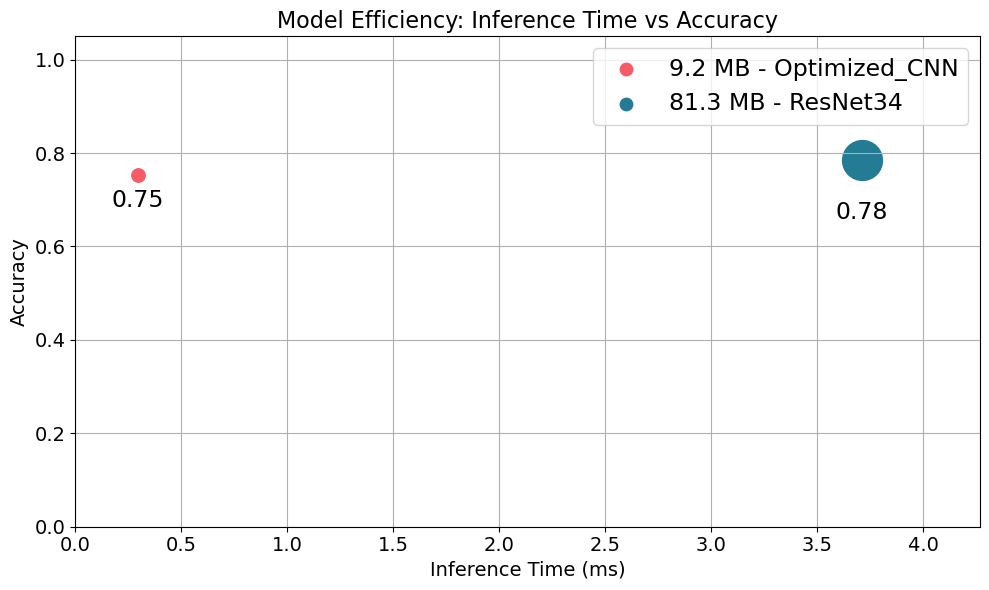

In [13]:
helper_utils.plot_efficiency_analysis(results_df)

In [14]:
def select_best_model_weighted(results, weights=None):
    """Selects the best model from a set of results using a weighted scoring system.

    Args:
        results: A pandas DataFrame containing model performance metrics,
                 with model names as the index.
        weights: An optional dictionary where keys are metric names (e.g.,
                 'accuracy') and values are their corresponding weights.
                 If None, default weights are used.

    Returns:
        A tuple containing the name of the best model and a dictionary of
        all models' weighted scores.
    """
    # Convert the DataFrame to a dictionary for easier processing.
    results = results.to_dict(orient="index")
    
    # If no weights are provided, define a default set that prioritizes accuracy.
    if weights is None:
        weights = {"accuracy": 0.5, "model_size_mb": 0.2, "inference_time_ms": 0.3}

    # Get the list of metrics to be considered from the weights dictionary.
    metrics = list(weights.keys())
    # Initialize a dictionary to store the normalized metric values for each model.
    normalized = {name: {} for name in results}

    # Loop through each metric to normalize its values across all models.
    for metric in metrics:
        # Extract all values for the current metric to find the min and max.
        values = [res[metric] for res in results.values()]
        min_val, max_val = min(values), max(values)
        # Calculate the range of values, avoiding division by zero.
        range_val = max_val - min_val if max_val != min_val else 1.0

        # Iterate through each model's results to calculate its normalized score.
        for name, res in results.items():
            value = res[metric]
            # Check the metric type to determine the normalization direction.
            if metric == "accuracy":
                # For accuracy, higher values are better, so normalize directly.
                norm_value = (value - min_val) / range_val
            else:
                # For size and time, lower values are better, so invert the normalization.
                norm_value = 1 - (value - min_val) / range_val
            # Store the calculated normalized value.
            normalized[name][metric] = norm_value

    # Calculate the final weighted score for each model.
    scores = {
        name: sum(weights[metric] * normalized[name][metric] for metric in metrics)
        for name in results
    }

    # Find the model with the highest overall score.
    best_model = max(scores.items(), key=lambda x: x[1])
    # Return the name of the best model and the dictionary of all scores.
    return best_model[0], scores

In [15]:
def select_best_model_constraint_based(results, max_size_mb, max_inference_ms):
    """Selects the best model based on hard constraints for size and inference time.

    Args:
        results: A pandas DataFrame of model performance metrics.
        max_size_mb: The maximum allowable model size in megabytes.
        max_inference_ms: The maximum allowable inference time in milliseconds.

    Returns:
        A tuple containing the name of the best model and a dictionary of all
        viable models. Returns None if no models meet the constraints.
    """
    # Convert the DataFrame to a dictionary for easier processing.
    results = results.to_dict(orient="index")
    
    # Filter the results to include only models that satisfy both constraints.
    viable_models = {
        name: metrics for name, metrics in results.items()
        if metrics["model_size_mb"] <= max_size_mb and
           metrics["inference_time_ms"] <= max_inference_ms
    }

    # Check if any models met the constraints.
    if not viable_models:
        # If no models are viable, notify the user.
        print("No models meet all constraints. Consider relaxing constraints.")
        return None

    # From the filtered list, select the model with the highest accuracy.
    best_model = max(viable_models.items(), key=lambda x: x[1]["accuracy"])
    # Return the name of the best model and all models that met the constraints.
    return best_model[0], viable_models

In [16]:
resnet_results = helper_utils.load_resnet_table()
resnet_results

,depth,accuracy,model_size_mb,inference_time_ms
model,,,,
ResNet18,18,0.92,42,2.0
ResNet34,34,0.93,81,3.8
ResNet50,50,0.94,98,5.0
ResNet101,101,0.95,168,8.0
ResNet152,152,0.96,230,12.0


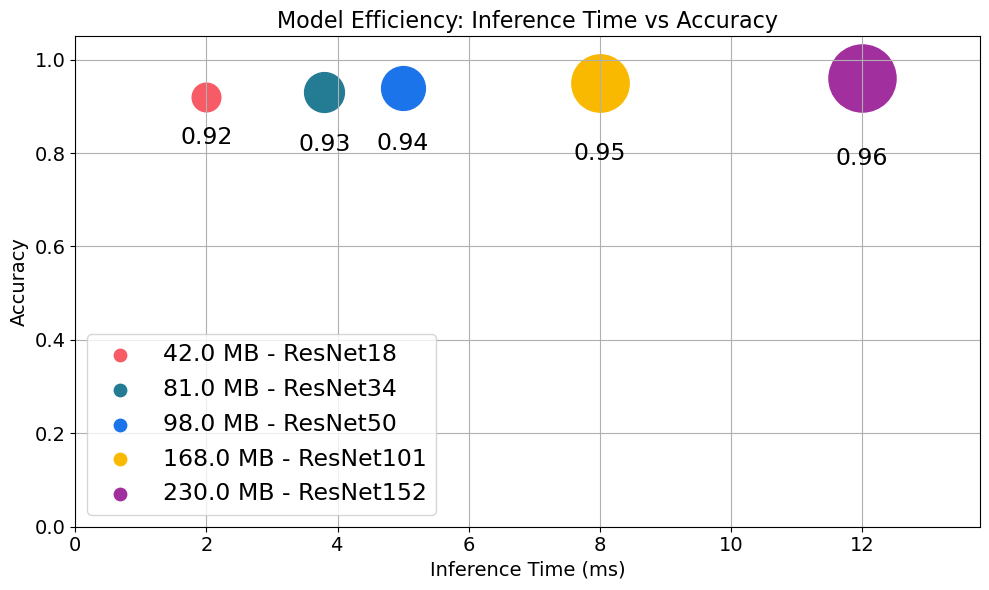

In [17]:
helper_utils.plot_efficiency_analysis(resnet_results)

In [18]:
best_model_weighted, weighted_scores = select_best_model_weighted(resnet_results)

print(f"Best model by weighted criteria: {best_model_weighted}")
print("Weighted scores:")
pprint(weighted_scores)

Best model by weighted criteria: ResNet50
Weighted scores:
{'ResNet101': 0.5609574468085103,
 'ResNet152': 0.5,
 'ResNet18': 0.5,
 'ResNet34': 0.5295106382978727,
 'ResNet50': 0.6004255319148929}


In [19]:
best_model_constrains, viable_models = select_best_model_constraint_based(resnet_results, max_size_mb=100, max_inference_ms=4)

print(f"Best model by constraints: {best_model_constrains}")
print("Viable models:")
pprint(viable_models)

Best model by constraints: ResNet34
Viable models:
{'ResNet18': {'accuracy': 0.92,
              'depth': 18,
              'inference_time_ms': 2.0,
              'model_size_mb': 42},
 'ResNet34': {'accuracy': 0.93,
              'depth': 34,
              'inference_time_ms': 3.8,
              'model_size_mb': 81}}
